In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re
import os.path as op

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import shutil

import nibabel as nib

import nilearn
from nilearn.masking import apply_mask
from nilearn.plotting import plot_img, plot_epi, plot_roi, plot_stat_map, view_img, plot_anat
from nilearn.image import load_img, threshold_img, math_img
from nilearn.input_data import NiftiMasker

import nitime
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv

import scipy

from bids import BIDSLayout

In [3]:
%matplotlib inline

In [4]:
print(' numpy: ', np.__version__, '\n',
      'nibabel: ', nib.__version__, '\n',
      'nilearn: ', nilearn.__version__, '\n',
      'nitime: ', nitime.__version__, '\n',
      'scipy: ', scipy.__version__)

 numpy:  1.17.5 
 nibabel:  3.1.1 
 nilearn:  0.6.2 
 nitime:  0.8.1 
 scipy:  1.2.1


### Define paths etc

In [6]:
sub = "NB"
ses = "20191221"

raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/")
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)
derivs_dir = os.path.abspath('/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams')
out_dir = os.path.abspath(f"{derivs_dir}/sub-{sub}")
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
preproc_layout = BIDSLayout(out_dir, validate=False)
# get only the big LGN masks, not any smaller M/P rois already assigned
rois = [f for f in
        preproc_layout.get(subject=sub, session=ses, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('P' not in f and 'M' not in f)]
ref_vol_name = f"sub-{sub}_ses-{ses}_refvol"
ref_vol_path = os.path.abspath(f"{out_dir}/{ref_vol_name}.nii.gz")
ref_vol_img = load_img(ref_vol_path)
mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_mask.nii.gz")
coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-coherence_map.nii")
anat_file = raw_layout.get(subject=sub, session=ses, extension=['nii.gz'], suffix="T1w", return_type='file')[0]

print("LGN rois:", '\n'.join(rois),
      "Reference BOLD volume:", ref_vol_path,
      "anat file: ", anat_file,
      "epi brainmask: ", mask_file, sep="\n")

//anaconda/envs/py37mri/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


LGN rois:
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
Reference BOLD volume:
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_refvol.nii.gz
anat file: 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/anat/sub-NB_ses-20191221_T1w.nii.gz
epi brainmask: 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz


#### For testing BIDS names

In [7]:
utils.isBIDSFile(mask_file)
utils.isBIDSFile(coh_fn)
utils.isBIDSFile(ref_vol_path)
for roi in rois:
    utils.isBIDSFile(roi)

sub-NB_ses-20191221_mask.nii.gz True
sub-NB_ses-20191221_task-hemi_desc-coherence_map.nii True
sub-NB_ses-20191221_refvol.nii.gz True
sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz True
sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz True


#### Make ref_vol from first dicom

In [ ]:
first_dicom = "/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun\ -\ 1/sb_bold_1p75mmISO_PSN_5/IM-0005-0001.dcm"
# first_dicom = "/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun - 1/sb_bold_1p75mmISO_PSN_6/IM-0006-0001.dcm"

In [ ]:
!ls {first_dicom}

In [ ]:
!pwd

In [ ]:
dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {ref_vol_name} -z y -o {out_dir} {first_dicom}"
print(dcm2niix_cmd)
os.system(dcm2niix_cmd)

In [ ]:
!ls {out_dir}

#### mcflirt the bold files using ref_vol as the reference image, save them as _preproc

In [8]:
from bids import BIDSLayout
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)
raw_bolds = sorted([f for f in raw_layout.get(subject=sub, session=ses, suffix='bold',
            extension=['nii.gz'], return_type='file')])

In [ ]:
print("\n".join(raw_bolds))

In [ ]:
for this_epi in raw_bolds:
    epi_name = os.path.basename(this_epi)
    epi_stub = epi_name.split('.')[0]
    epi_stub_parts = epi_stub.split('_')
    epi_stub_parts.insert(-1, 'desc-preproc')
    epi_stub_mcf = '_'.join(epi_stub_parts)
    full_outpath = os.path.join(out_dir, f"sub-{sub}", f"ses-{ses}", "func", epi_stub_mcf)
    mcflirt_cmd = f"mcflirt -reffile {ref_vol_path} -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

In [9]:
!ls /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/

sub-NB_ses-20191221_task-hemi_run-01_desc-preproc_bold.nii.gz
sub-NB_ses-20191221_task-hemi_run-01_desc-preproc_bold.par
sub-NB_ses-20191221_task-hemi_run-02_desc-preproc_bold.nii.gz
sub-NB_ses-20191221_task-hemi_run-02_desc-preproc_bold.par
sub-NB_ses-20191221_task-mp_run-01_desc-preproc_bold.nii.gz
sub-NB_ses-20191221_task-mp_run-01_desc-preproc_bold.par
sub-NB_ses-20191221_task-mp_run-02_desc-preproc_bold.nii.gz
sub-NB_ses-20191221_task-mp_run-02_desc-preproc_bold.par
sub-NB_ses-20191221_task-mp_run-03_desc-preproc_bold.nii.gz
sub-NB_ses-20191221_task-mp_run-03_desc-preproc_bold.par
sub-NB_ses-20191221_task-mp_run-04_desc-preproc_bold.nii.gz
sub-NB_ses-20191221_task-mp_run-04_desc-preproc_bold.par
sub-NB_ses-20191221_task-mp_run-05_desc-preproc_bold.nii.gz
sub-NB_ses-20191221_task-mp_run-05_desc-preproc_bold.par
sub-NB_ses-20191221_task-mp_run-06_desc-preproc_bold.nii.gz
sub-NB_ses-20191221_task-mp_run-06_desc-preproc_bold.par
sub-NB_ses-20191221_task-mp_run-07_desc-preproc_bold.nii

#### Move event and json files

In [ ]:
events_glob = f"{raw_data_dir}/ses-{ses}/func/*events*.tsv"
print("\n".join(glob.glob(events_glob)))
task_json_glob = f"{raw_data_dir}/ses-{ses}/func/*task*json"
print("\n".join(glob.glob(task_json_glob)))

### Write hemifield event files (they are all identical)

In [ ]:
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-01_events.tsv")
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-02_events.tsv")

In [ ]:
for e in glob.glob(events_glob):
    fileparts = op.split(e)[-1].split('_')[:-1]
    fileparts[0] = f"sub-{sub}"
    #runpart = fileparts[-2]
    #print('_'.join(fileparts), fileparts[-2])
    fn = '_'.join(fileparts)
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}.tsv"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [ ]:

for e in glob.glob(task_json_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [ ]:
blocks_in_order = ['L', 'R']
for thisrun in [1]:
    events_fn = f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-{thisrun:02d}_events.tsv"
    events_file_contents = f"onset\tduration\ttrial_type\n"
    time_between_onsets = 13.5
    for i in range(22):
        events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
    #with open(events_fn, 'w') as f:
        #f.write(events_file_contents)
    print(events_fn, '\n', events_file_contents)

## GLM invocation from a cell

### Individual GLMs

Run the GLMs for each task using all runs

In [10]:
hemi_workdir = utils.run_fixedeffects_glm(sub, ses, "hemi", [1, 2], raw_data_dir, out_dir)

201008-15:41:59,351 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
201008-15:41:59,447 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
201008-15:41:59,475 nipype.workflow INFO:
	 Running in parallel.
201008-15:41:59,487 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:41:59,625 nipype.workflow INFO:
	 [Job 0] Cached (fixedeffects.BIDSDataGrabber).


//anaconda/envs/py37mri/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
//anaconda/envs/py37mri/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


201008-15:42:01,488 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:42:01,578 nipype.workflow INFO:
	 [Job 1] Cached (fixedeffects.modelfit.maskemerge).


//anaconda/envs/py37mri/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


201008-15:42:03,494 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:42:03,579 nipype.workflow INFO:
	 [Job 14] Cached (_trim0).
201008-15:42:03,582 nipype.workflow INFO:
	 [Job 15] Cached (_trim1).
201008-15:42:03,585 nipype.workflow INFO:
	 [Job 16] Cached (_tsv2subjinfo0).
201008-15:42:05,494 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:42:05,585 nipype.workflow INFO:
	 [Job 2] Cached (fixedeffects.modelfit.trim).
201008-15:42:05,589 nipype.workflow INFO:
	 [Job 17] Cached (_tsv2subjinfo1).
201008-15:42:07,587 nipype.workflow INFO:
	 [Job 4] Cached (fixedeffects.modelfit.tsv2subjinfo).
201008-15:42:09,499 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:42:09,610 nipype.workflow INFO:
	 [Job 18] Cached (_applymask0).
201008-15:4

In [11]:
hemi_datasink = f"{hemi_workdir}/fixedeffects/modelfit/datasink"
print(hemi_workdir, hemi_datasink, sep="\n")
!ls {hemi_datasink}

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/datasink
_0xd0c411694dc49f1e6b44f29496474657.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir


In [12]:
mp_workdir = utils.run_fixedeffects_glm(sub, ses, "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_data_dir, out_dir)

201008-15:42:52,270 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
201008-15:42:52,333 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
201008-15:42:52,349 nipype.workflow INFO:
	 Running in parallel.
201008-15:42:52,353 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:42:52,602 nipype.workflow INFO:
	 [Job 0] Cached (fixedeffects.BIDSDataGrabber).
201008-15:42:54,358 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:42:54,461 nipype.workflow INFO:
	 [Job 1] Cached (fixedeffects.modelfit.maskemerge).
201008-15:42:56,360 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 16 jobs ready. Free memory (GB): 14.

201008-15:43:44,508 nipype.workflow INFO:
	 [Job 62] Cached (_modelestimate0).
201008-15:43:44,510 nipype.workflow INFO:
	 [Job 63] Cached (_modelestimate1).
201008-15:43:44,513 nipype.workflow INFO:
	 [Job 64] Cached (_modelestimate2).
201008-15:43:46,423 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:43:46,513 nipype.workflow INFO:
	 [Job 65] Cached (_modelestimate3).
201008-15:43:46,516 nipype.workflow INFO:
	 [Job 66] Cached (_modelestimate4).
201008-15:43:46,520 nipype.workflow INFO:
	 [Job 67] Cached (_modelestimate5).
201008-15:43:48,427 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
201008-15:43:48,514 nipype.workflow INFO:
	 [Job 68] Cached (_modelestimate6).
201008-15:43:48,517 nipype.workflow INFO:
	 [Job 69] Cached (_modelestimate7).
201008-15:43:50,432 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 j

In [13]:
mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
print(mp_workdir, mp_datasink, sep="\n")
!ls {mp_datasink}

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/datasink
_0xb263f2a359caa5cc3ed37d257df6f85d.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir


In [14]:
hemi_RL_l1, hemi_RL_l2 = utils.get_model_outputs(hemi_datasink, [1])
hemi_LR_l1, hemi_LR_l2 = utils.get_model_outputs(hemi_datasink, [2])
mp_l1, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
pm_l1, pm_l2 = utils.get_model_outputs(mp_datasink, [2])
visresp_l1, visresp_l2 = utils.get_model_outputs(mp_datasink, [3])

In [15]:
#print(f"fsleyes {ref_vol_path} {anat_file} {hemi_LR_l2[0]} {hemi_RL_l2[0]} {mp_l2[0]} {pm_l2[0]}")
print(f"fsleyes {ref_vol_path} {anat_file} {hemi_LR_l2[0]} {hemi_RL_l2[0]} {visresp_l2[0]}")

fsleyes /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_refvol.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/anat/sub-NB_ses-20191221_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/datasink/stats_dir/_flameo1/stats/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz


In [16]:
beta_RL = hemi_RL_l2[0]
beta_LR = hemi_LR_l2[0]
beta_MP = mp_l2[0]
beta_PM = pm_l2[0]
beta_MP_img = load_img(beta_MP)

In [17]:
beta_RL, beta_MP

('/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz')

### Grab the affine transformation matrix so we can convert EPI to scanner space

In [18]:
epi_vox_center = (np.array(ref_vol_img.get_fdata().shape) - 1) / 2.
print('epi vox center: ', epi_vox_center)

epi vox center:  [63.5 63.5 10. ]


### Assign 80/20 or whatever

In [19]:
print(rois)

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz']


In [20]:
for roi in rois:
    utils.roi_stats({roi:load_img(roi)}, ref_vol_img)

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
(78, 3)
[77 61 14] [72 55 10]
[5 6 4] [2.4359 2.4487 2.1667]
[74.5641 58.5513 11.8333] [-18.4872  -6.8333   1.2789]
****
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
(47, 3)
[54 62 13] [49 57 11]
[5 5 2] [2.7234 2.2979 0.9787]
[51.2766 59.7021 12.0213] [22.266  -4.8575  1.789 ]
****


In [21]:
_, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
beta_MP_img = load_img(beta_MP)

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
(78, 3)
[77 61 14] [72 55 10]
[5 6 4] [2.4359 2.4487 2.1667]
[74.5641 58.5513 11.8333] [-18.4872  -6.8333   1.2789]
****
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
will partition at 80% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz
Mask contains 78 voxels and 80th percentile is 2.7522514343261717


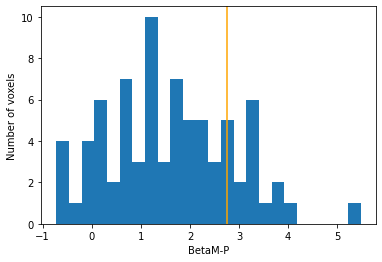

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz: 16 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz: 62 voxels
[62, 16, 77236]
[62, 16, 78]


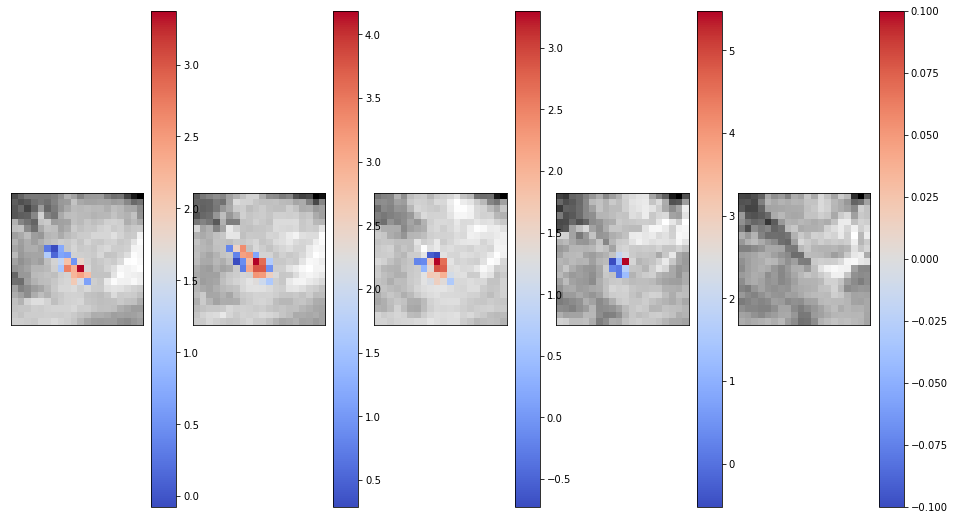

M
(16, 3)
[76 60 13] [72 57 10]
[4 3 3] [1.625  1.0625 1.25  ]
[74.375  58.9375 11.75  ] [-18.1562  -6.147    1.1949]
****
P
(62, 3)
[77 61 14] [72 55 10]
[5 6 4] [2.3871 2.5484 2.1452]
[74.6129 58.4516 11.8548] [-18.5726  -7.0104   1.3005]
****
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
(47, 3)
[54 62 13] [49 57 11]
[5 5 2] [2.7234 2.2979 0.9787]
[51.2766 59.7021 12.0213] [22.266  -4.8575  1.789 ]
****
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
will partition at 80% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz
Mask contains 47 voxels and 80th percentile is 3.076976537704468


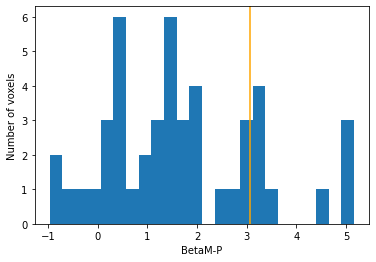

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz: 10 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz: 37 voxels
[37, 10, 77236]
[37, 10, 47]


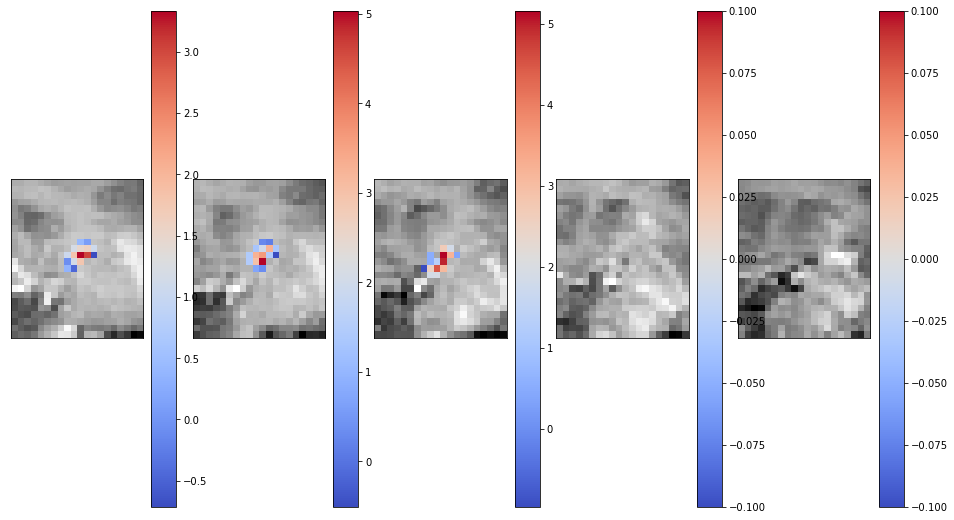

M
(10, 3)
[53 61 13] [50 59 11]
[3 2 2] [1.5 1.  1.4]
[51.5 60.  11.6] [21.875  -4.2715  1.102 ]
****
P
(37, 3)
[54 62 13] [49 57 11]
[5 5 2] [2.7838 2.3784 0.8649]
[51.2162 59.6216 12.1351] [22.3716 -5.0158  1.9746]
****


In [22]:
for roi in rois:
    utils.roi_stats({roi:load_img(roi)}, ref_vol_img)
    if 'desc-L' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP, 80, ref_vol_img, 'L')
    elif 'desc-R' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP, 80, ref_vol_img, 'R')
    else:
        print('Error - not sure which hemisphere roi is in')
    utils.roi_stats({'M':load_img(M_roi), 'P':load_img(P_roi)}, ref_vol_img)

### Cross-validation

In [31]:
# add code to:
# compute threshold statistics (variance etc) across xval runs
# 
def cross_val_glm(sub, ses, task, runs, raw_layout, preproc_layout):
    print(raw_layout, preproc_layout, sep="\n")
    raw_data_dir = raw_layout.root
    out_dir = preproc_layout.root
    working_dirs = []
    for i,r in enumerate(runs):
        other_runs = [*runs[0:i], *runs[i+1:]]
        print(i, r, other_runs)
        wdir = utils.run_fixedeffects_glm(sub, ses, task, other_runs,
                    raw_data_dir, out_dir, working_dir_suffix=f"excrun{r}")
        working_dirs.append(wdir)
    return working_dirs

In [68]:
# beta_imgs = []
# threshold = 6.0
# for workdir in hemi_xval_outputs:
#     datasink = f"{workdir}/fixedeffects/modelfit/datasink"
#     xval_suffix = op.split(workdir)[-1].split('_')[-1] # e.g. 'excrun1'
#     print("xvalRUN", workdir) #, datasink, sep="\n")
#     #!ls {mp_datasink}
#     l1, l2 = utils.get_model_outputs(datasink, [1])
#     beta = l2[0]
#     beta_img = load_img(beta)
#     print(beta, beta_img.shape)
#     #thresholded_beta = threshold_img(beta_img, threshold, copy=True)
#     bin_beta = math_img(f'img > {threshold}', img=beta_img)
#     bin_beta.to_filename(f"{out_dir}/sub-{sub}_ses-{ses}_hemi_mask_{xval_suffix}_thr{threshold:.0f}.nii.gz")
#     #print(np.count_nonzero(thresholded_beta.get_fdata()), np.count_nonzero(bin_beta.get_fdata()))
#     beta_imgs.append(bin_beta)
# print(beta_imgs)
# intersect_img = nilearn.masking.intersect_masks(beta_imgs, threshold=1)
# intersect_img.to_filename(f"{out_dir}/sub-{sub}-ses-{ses}_hemi_intersect_mask_thr{threshold:.0f}.nii.gz")
# print((np.logical_and(*[b.get_fdata() for b in beta_imgs])).to_filename)

xvalRUN /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi_excrun1
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi_excrun1/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz (128, 128, 21)
xvalRUN /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi_excrun2
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi_excrun2/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz (128, 128, 21)
[<nibabel.nifti1.Nifti1Image object at 0x122058850>, <nibabel.nifti1.Nifti1Image object at 0x124230410>]
1665


In [32]:
mp_xval_outputs = cross_val_glm(sub, ses, "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_layout, preproc_layout)

BIDS Layout: ...GN/BIDS/NB_20191221_odd/sub-NB | Subjects: 1 | Sessions: 1 | Runs: 8
BIDS Layout: ...odd/derivatives/streams/sub-NB | Subjects: 1 | Sessions: 1 | Runs: 8
0 1 [2, 3, 4, 5, 6, 7, 8]
200903-00:40:02,9 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun1/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
200903-00:40:02,111 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
200903-00:40:02,134 nipype.workflow INFO:
	 Running in parallel.
200903-00:40:02,139 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:40:02,309 nipype.workflow INFO:
	 [Job 0] Cached (fixedeffects.BIDSDataGrabber).


//anaconda/envs/py37mri/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
//anaconda/envs/py37mri/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


200903-00:40:04,144 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:40:04,279 nipype.workflow INFO:
	 [Job 1] Cached (fixedeffects.modelfit.maskemerge).


//anaconda/envs/py37mri/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


200903-00:40:06,149 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:40:06,256 nipype.workflow INFO:
	 [Job 14] Cached (_trim0).
200903-00:40:06,258 nipype.workflow INFO:
	 [Job 15] Cached (_trim1).
200903-00:40:06,264 nipype.workflow INFO:
	 [Job 16] Cached (_trim2).
200903-00:40:08,150 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 11 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:40:08,268 nipype.workflow INFO:
	 [Job 17] Cached (_trim3).
200903-00:40:08,272 nipype.workflow INFO:
	 [Job 18] Cached (_trim4).
200903-00:40:08,275 nipype.workflow INFO:
	 [Job 19] Cached (_trim5).
200903-00:40:10,154 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:40:10,275 nipype.workflow INFO:
	 [Job 20] Cached (_trim6).
200903-00:40:10,281 nipype.workflow INFO:
	 [Job 21] Cached (_tsv2subjinfo0)

200903-00:41:06,361 nipype.workflow INFO:
	 [Job 11] Cached (fixedeffects.modelfit.copemerge).
200903-00:41:10,244 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:41:10,384 nipype.workflow INFO:
	 [Job 67] Cached (_flameo0).
200903-00:41:10,389 nipype.workflow INFO:
	 [Job 68] Cached (_flameo1).
200903-00:41:12,249 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:41:12,538 nipype.workflow INFO:
	 [Job 12] Cached (fixedeffects.modelfit.flameo).
200903-00:41:14,433 nipype.workflow INFO:
	 [Node] Setting-up "fixedeffects.modelfit.datasink" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun1/fixedeffects/modelfit/datasink".
200903-00:41:14,527 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
200903-00:41:16,258 nipype.workflow INFO:
	 [Multi

200903-00:42:07,168 nipype.workflow INFO:
	 [Job 54] Cached (_modelgen5).
200903-00:42:09,48 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:42:09,167 nipype.workflow INFO:
	 [Job 55] Cached (_modelgen6).
200903-00:42:11,217 nipype.workflow INFO:
	 [Job 7] Cached (fixedeffects.modelfit.modelgen).
200903-00:42:15,62 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 7 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:42:15,176 nipype.workflow INFO:
	 [Job 56] Cached (_modelestimate0).
200903-00:42:15,179 nipype.workflow INFO:
	 [Job 57] Cached (_modelestimate1).
200903-00:42:15,187 nipype.workflow INFO:
	 [Job 58] Cached (_modelestimate2).
200903-00:42:17,65 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:42:17,227 nipype.workflow INFO:
	 [Job 59] Cached (_modelestimate3).
200903-00:42:1

200903-00:43:06,193 nipype.workflow INFO:
	 [Job 37] Cached (_modelspec2).
200903-00:43:08,29 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:43:08,181 nipype.workflow INFO:
	 [Job 38] Cached (_modelspec3).
200903-00:43:08,195 nipype.workflow INFO:
	 [Job 39] Cached (_modelspec4).
200903-00:43:08,204 nipype.workflow INFO:
	 [Job 40] Cached (_modelspec5).
200903-00:43:10,35 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:43:10,246 nipype.workflow INFO:
	 [Job 41] Cached (_modelspec6).
200903-00:43:12,205 nipype.workflow INFO:
	 [Job 5] Cached (fixedeffects.modelfit.modelspec).
200903-00:43:16,43 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 7 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:43:16,216 nipype.workflow INFO:
	 [Job 42] Cached (_level1design0).
200903-00:43:16,223 nipy

200903-00:44:13,469 nipype.workflow INFO:
	 [Job 20] Cached (_trim6).
200903-00:44:13,476 nipype.workflow INFO:
	 [Job 21] Cached (_tsv2subjinfo0).
200903-00:44:13,482 nipype.workflow INFO:
	 [Job 22] Cached (_tsv2subjinfo1).
200903-00:44:15,138 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:44:15,241 nipype.workflow INFO:
	 [Job 2] Cached (fixedeffects.modelfit.trim).
200903-00:44:15,247 nipype.workflow INFO:
	 [Job 23] Cached (_tsv2subjinfo2).
200903-00:44:15,251 nipype.workflow INFO:
	 [Job 24] Cached (_tsv2subjinfo3).
200903-00:44:17,144 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:44:17,333 nipype.workflow INFO:
	 [Job 25] Cached (_tsv2subjinfo4).
200903-00:44:17,338 nipype.workflow INFO:
	 [Job 26] Cached (_tsv2subjinfo5).
200903-00:44:17,349 nipype.workflow INFO:
	 [Job 27] Cached (_tsv2subjinfo6).
200903-

200903-00:45:17,471 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
200903-00:45:19,264 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 2/3.
                     Currently running:
                       * fixedeffects.modelfit.datasink
200903-00:45:20,554 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.datasink".
200903-00:45:21,263 nipype.workflow INFO:
	 [Job 13] Completed (fixedeffects.modelfit.datasink).
200903-00:45:21,267 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
4 5 [1, 2, 3, 4, 6, 7, 8]
200903-00:45:23,566 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun5/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
200903-00:45:23,665 nipype.workflow INFO:
	 Workflow fixedeffec

200903-00:46:15,879 nipype.workflow INFO:
	 [Job 59] Cached (_modelestimate3).
200903-00:46:15,882 nipype.workflow INFO:
	 [Job 60] Cached (_modelestimate4).
200903-00:46:15,886 nipype.workflow INFO:
	 [Job 61] Cached (_modelestimate5).
200903-00:46:17,779 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:46:17,886 nipype.workflow INFO:
	 [Job 62] Cached (_modelestimate6).
200903-00:46:19,887 nipype.workflow INFO:
	 [Job 8] Cached (fixedeffects.modelfit.modelestimate).
200903-00:46:21,785 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:46:21,891 nipype.workflow INFO:
	 [Job 9] Cached (fixedeffects.modelfit.l2model).
200903-00:46:23,785 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:46:23,893 nipype.workflow INFO:
	 [Job 63] Cached (_

200903-00:47:12,357 nipype.workflow INFO:
	 [Job 42] Cached (_level1design0).
200903-00:47:12,363 nipype.workflow INFO:
	 [Job 43] Cached (_level1design1).
200903-00:47:12,368 nipype.workflow INFO:
	 [Job 44] Cached (_level1design2).
200903-00:47:14,256 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:47:14,364 nipype.workflow INFO:
	 [Job 45] Cached (_level1design3).
200903-00:47:14,368 nipype.workflow INFO:
	 [Job 46] Cached (_level1design4).
200903-00:47:14,372 nipype.workflow INFO:
	 [Job 47] Cached (_level1design5).
200903-00:47:16,260 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:47:16,369 nipype.workflow INFO:
	 [Job 48] Cached (_level1design6).
200903-00:47:18,367 nipype.workflow INFO:
	 [Job 6] Cached (fixedeffects.modelfit.level1design).
200903-00:47:22,268 nipype.workflow INFO:
	 [MultiProc] Running 0 tas

200903-00:48:12,922 nipype.workflow INFO:
	 [Job 26] Cached (_tsv2subjinfo5).
200903-00:48:12,926 nipype.workflow INFO:
	 [Job 27] Cached (_tsv2subjinfo6).
200903-00:48:14,788 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:48:14,898 nipype.workflow INFO:
	 [Job 4] Cached (fixedeffects.modelfit.tsv2subjinfo).
200903-00:48:14,901 nipype.workflow INFO:
	 [Job 28] Cached (_applymask0).
200903-00:48:14,904 nipype.workflow INFO:
	 [Job 29] Cached (_applymask1).
200903-00:48:16,788 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:48:16,925 nipype.workflow INFO:
	 [Job 30] Cached (_applymask2).
200903-00:48:16,928 nipype.workflow INFO:
	 [Job 31] Cached (_applymask3).
200903-00:48:16,931 nipype.workflow INFO:
	 [Job 32] Cached (_applymask4).
200903-00:48:18,792 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs 

200903-00:49:19,254 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
200903-00:49:19,276 nipype.workflow INFO:
	 Running in parallel.
200903-00:49:19,280 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:49:19,412 nipype.workflow INFO:
	 [Job 0] Cached (fixedeffects.BIDSDataGrabber).
200903-00:49:21,284 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:49:21,386 nipype.workflow INFO:
	 [Job 1] Cached (fixedeffects.modelfit.maskemerge).
200903-00:49:23,288 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:49:23,399 nipype.workflow INFO:
	 [Job 14] Cached (_trim0).
200903-00:49:23,402 nipype.workflow INFO:
	 [Job 15] Cached (_trim1).
200903-00:49:23,406 nipype.workflow INFO:
	 [Job 16]

200903-00:50:19,497 nipype.workflow INFO:
	 [Job 63] Cached (_varcopemerge0).
200903-00:50:19,499 nipype.workflow INFO:
	 [Job 64] Cached (_varcopemerge1).
200903-00:50:19,503 nipype.workflow INFO:
	 [Job 65] Cached (_copemerge0).
200903-00:50:21,399 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:50:21,500 nipype.workflow INFO:
	 [Job 10] Cached (fixedeffects.modelfit.varcopemerge).
200903-00:50:21,504 nipype.workflow INFO:
	 [Job 66] Cached (_copemerge1).
200903-00:50:23,408 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:50:23,517 nipype.workflow INFO:
	 [Job 11] Cached (fixedeffects.modelfit.copemerge).
200903-00:50:27,427 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200903-00:50:27,534 nipype.workflow INFO:
	 [Job 67] Cached (_flameo0

In [33]:
mp_xval_outputs

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun1',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun2',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun3',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun4',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun5',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun6',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun7',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun8']

//anaconda/envs/py37mri/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


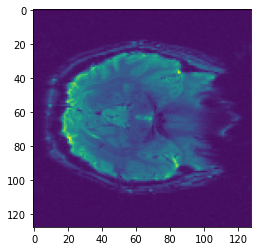

In [34]:
plt.imshow(ref_vol_img.get_data()[:,:,13])

xvalRUN
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun1
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun1/fixedeffects/modelfit/datasink
Left:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz
Mask contains 67 voxels and 20th percentile is 0.7601511240005494


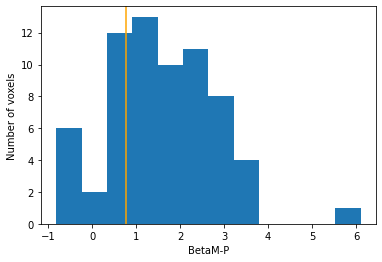

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz: 53 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz: 14 voxels
[14, 53, 77236]
P: ['73.71', '58.00', '10.71']
M: ['74.68', '59.04', '11.17']
[14, 53, 67]


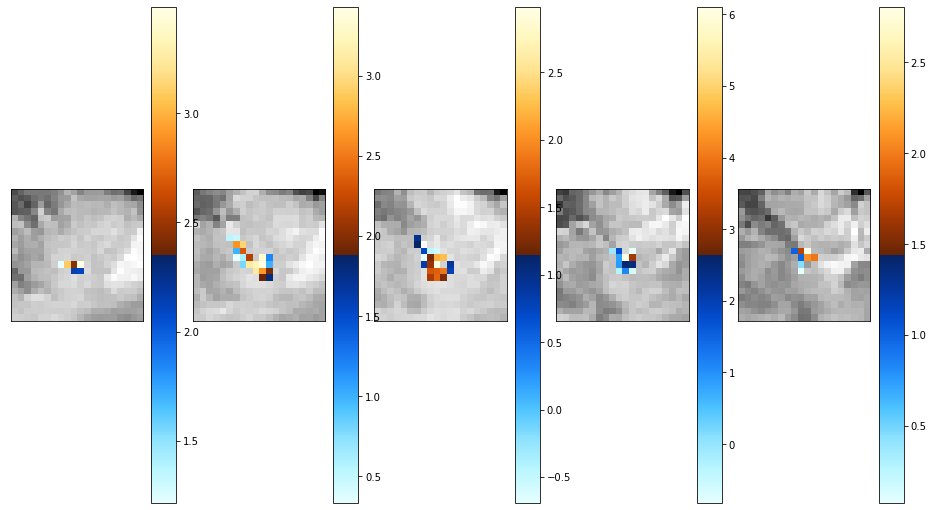

Right:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz
Mask contains 65 voxels and 20th percentile is 0.050532242655754164


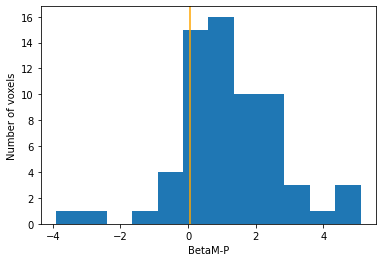

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz: 52 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz: 13 voxels
[13, 52, 77236]
P: ['51.92', '59.31', '11.85']
M: ['51.44', '59.37', '12.19']
[13, 52, 65]


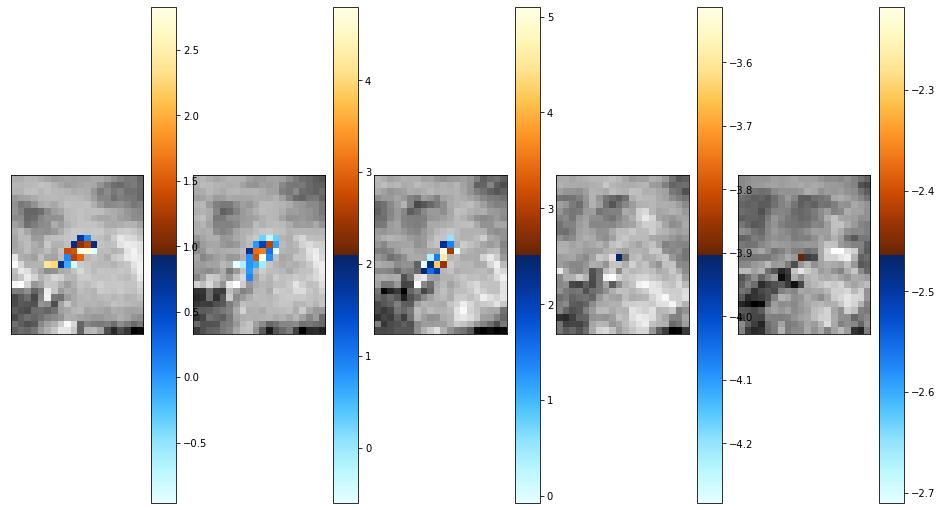

*********

xvalRUN
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun2
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun2/fixedeffects/modelfit/datasink
Left:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz
Mask contains 67 voxels and 20th percentile is 0.4547502517700196


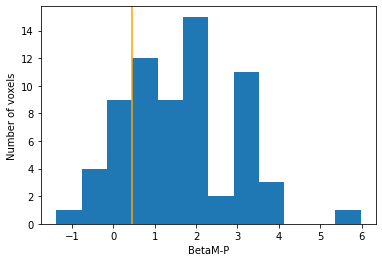

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz: 53 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz: 14 voxels
[14, 53, 77236]
P: ['73.93', '58.50', '10.14']
M: ['74.62', '58.91', '11.32']
[14, 53, 67]


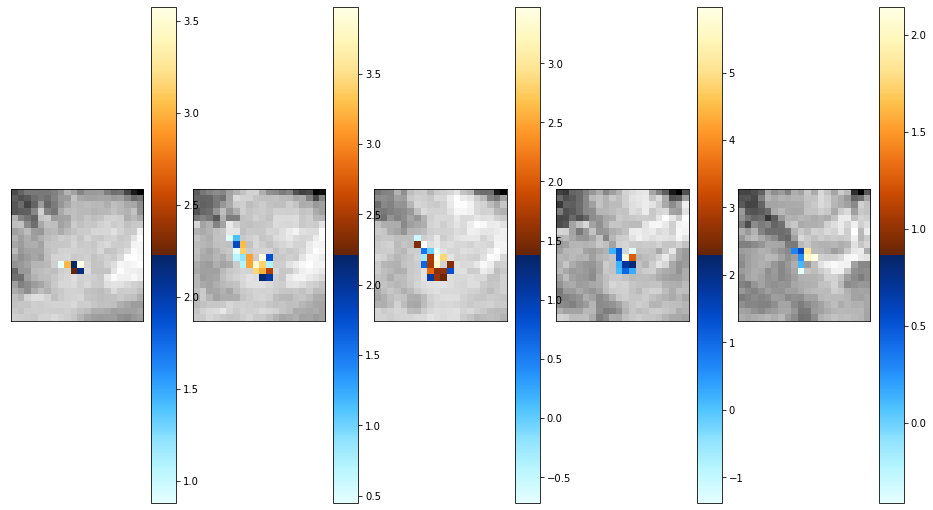

Right:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz
Mask contains 65 voxels and 20th percentile is -0.1181277573108673


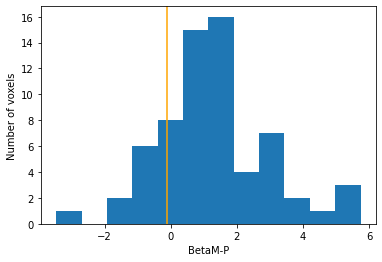

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz: 52 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz: 13 voxels
[13, 52, 77236]
P: ['51.77', '59.31', '11.69']
M: ['51.48', '59.37', '12.23']
[13, 52, 65]


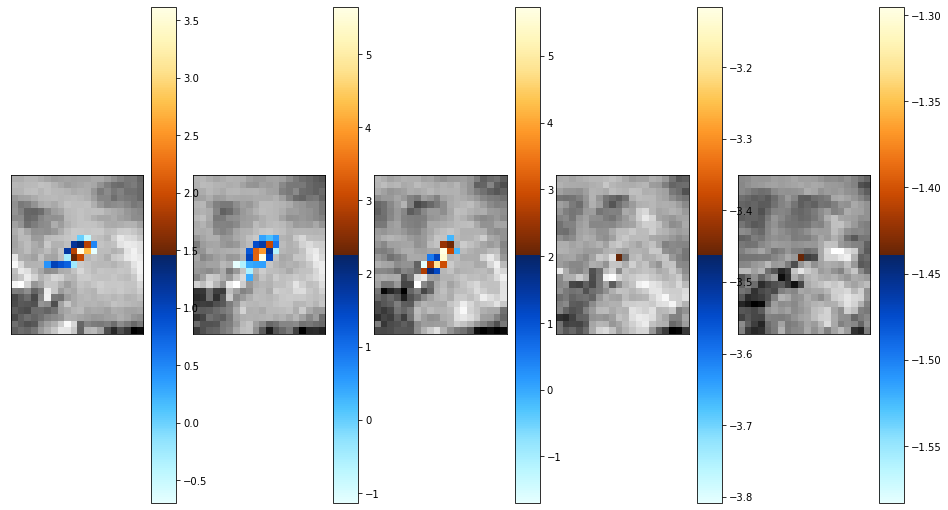

*********

xvalRUN
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun3
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun3/fixedeffects/modelfit/datasink
Left:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz
Mask contains 67 voxels and 20th percentile is 0.39018584489822394


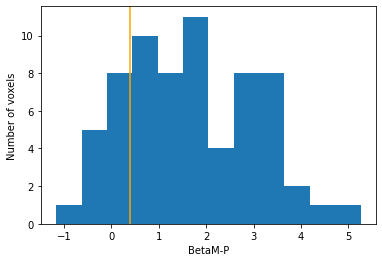

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz: 53 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz: 14 voxels
[14, 53, 77236]
P: ['73.86', '58.21', '10.29']
M: ['74.64', '58.98', '11.28']
[14, 53, 67]


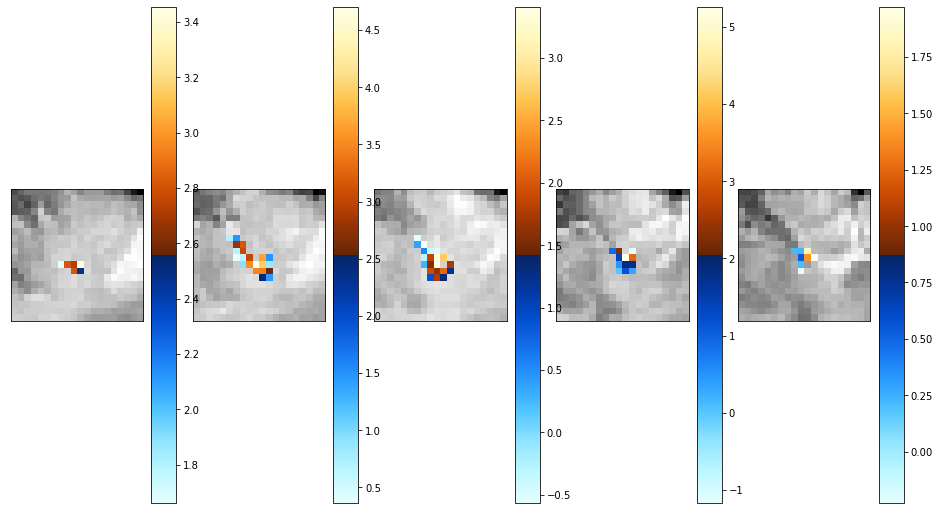

Right:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz
Mask contains 65 voxels and 20th percentile is 0.0811815917491913


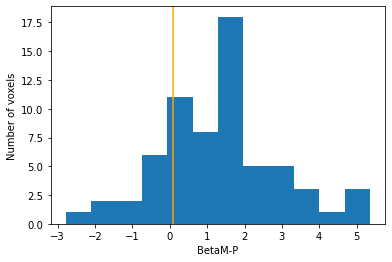

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz: 52 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz: 13 voxels
[13, 52, 77236]
P: ['52.23', '58.77', '12.08']
M: ['51.37', '59.50', '12.13']
[13, 52, 65]


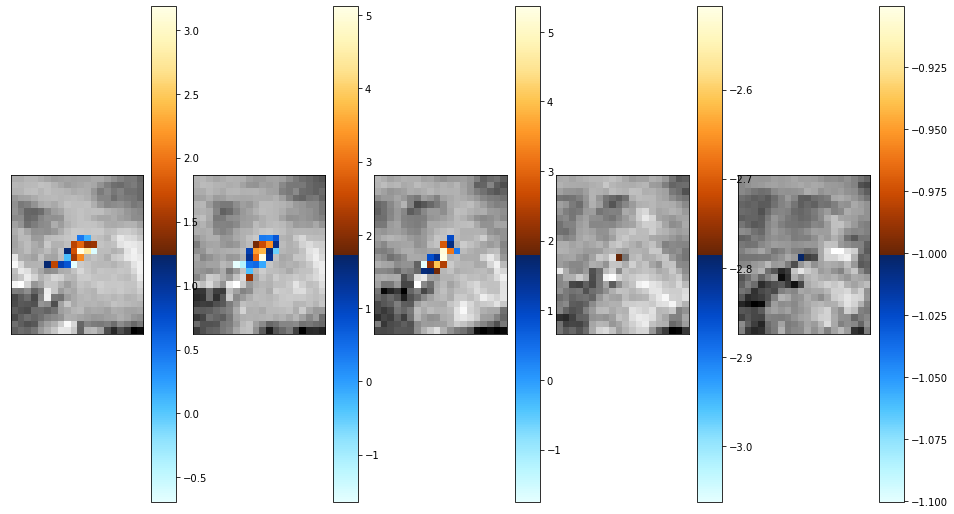

*********

xvalRUN
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun4
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun4/fixedeffects/modelfit/datasink
Left:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz
Mask contains 67 voxels and 20th percentile is 0.5375173330307007


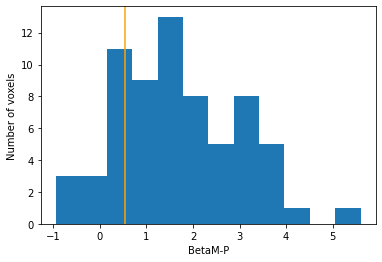

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz: 53 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz: 14 voxels
[14, 53, 77236]
P: ['73.86', '58.36', '10.07']
M: ['74.64', '58.94', '11.34']
[14, 53, 67]


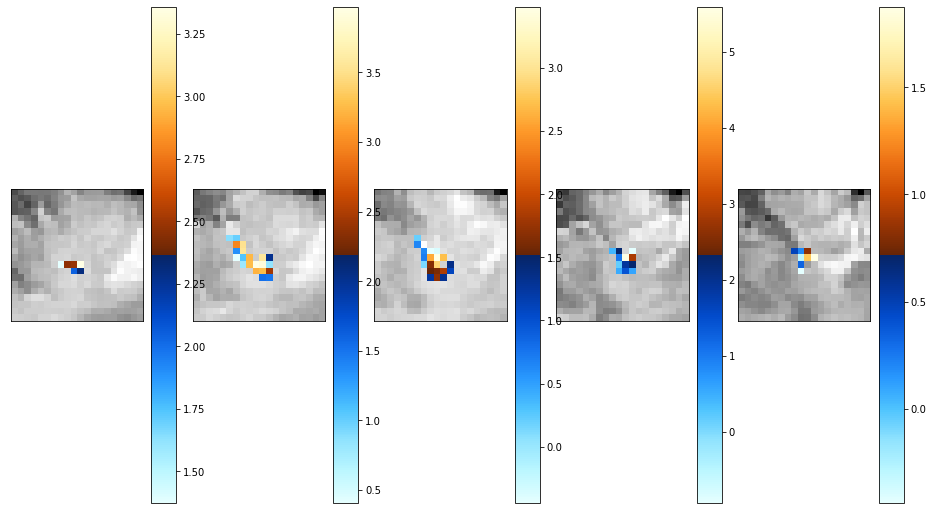

Right:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz
Mask contains 65 voxels and 20th percentile is 0.30210028886795043


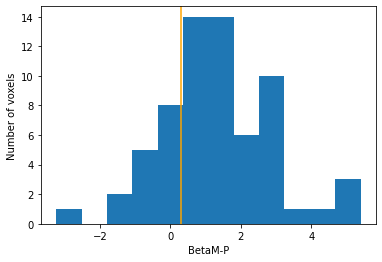

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz: 52 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz: 13 voxels
[13, 52, 77236]
P: ['52.08', '58.77', '11.92']
M: ['51.40', '59.50', '12.17']
[13, 52, 65]


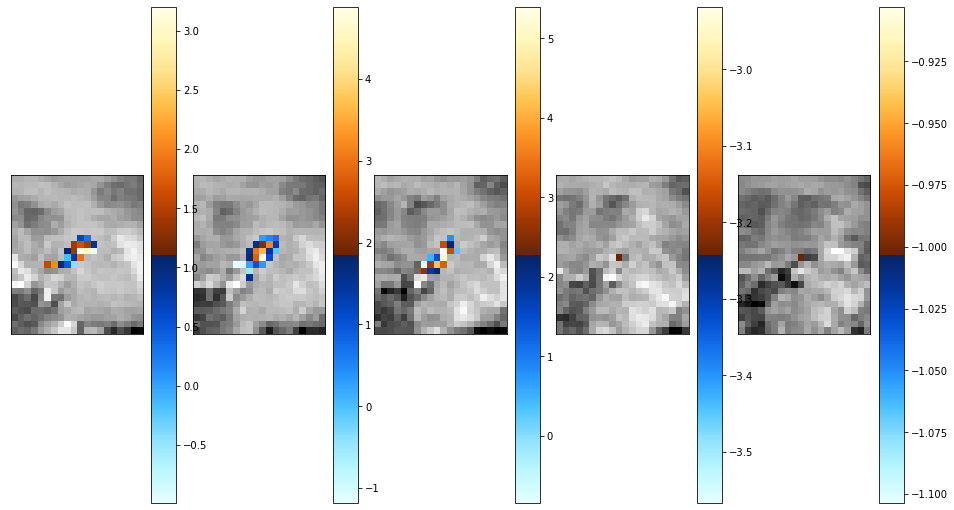

*********

xvalRUN
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun5
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun5/fixedeffects/modelfit/datasink
Left:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz
Mask contains 67 voxels and 20th percentile is 0.39125795364379884


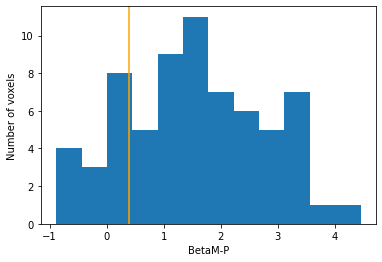

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz: 53 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz: 14 voxels
[14, 53, 77236]
P: ['73.57', '57.71', '10.57']
M: ['74.72', '59.11', '11.21']
[14, 53, 67]


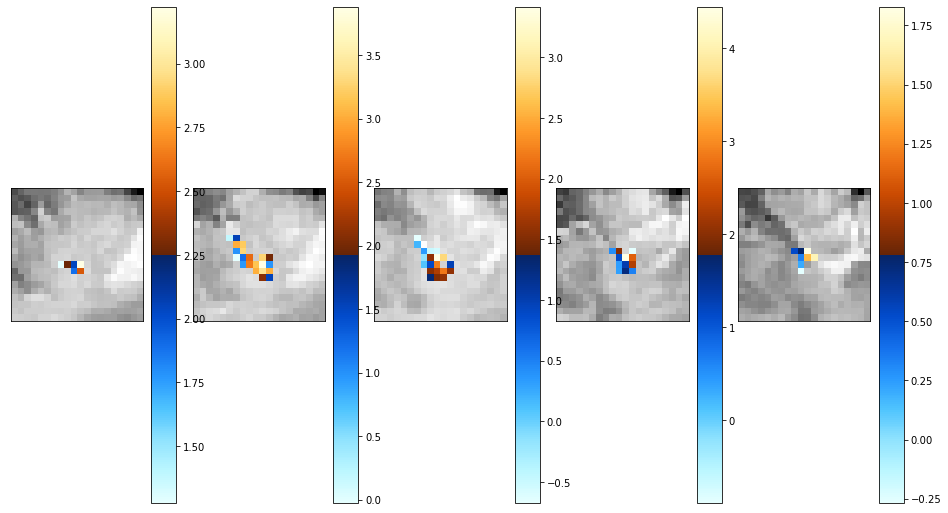

Right:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz
Mask contains 65 voxels and 20th percentile is 0.13925127983093266


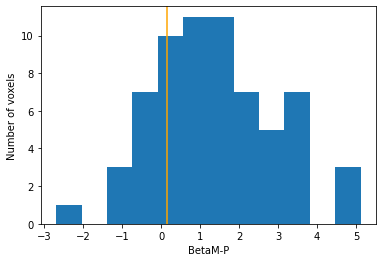

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz: 52 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz: 13 voxels
[13, 52, 77236]
P: ['51.54', '59.23', '11.92']
M: ['51.54', '59.38', '12.17']
[13, 52, 65]


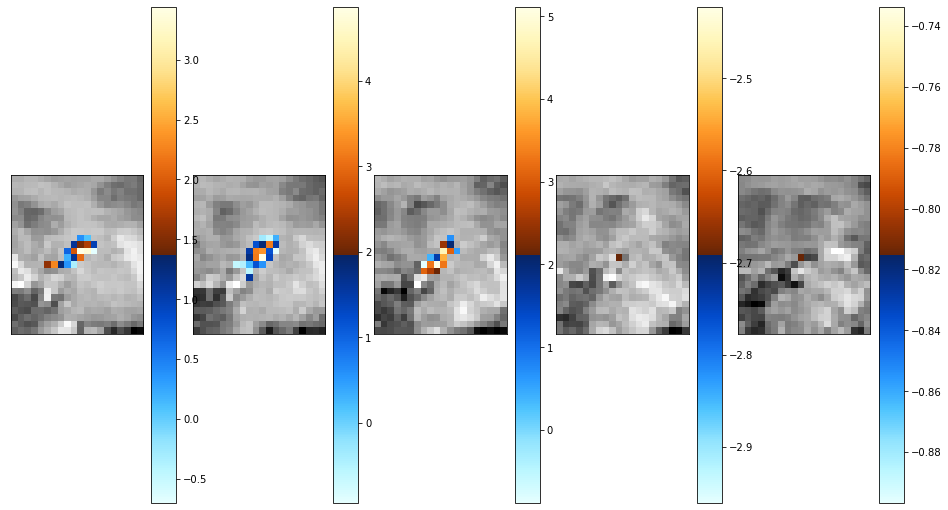

*********

xvalRUN
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun6
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun6/fixedeffects/modelfit/datasink
Left:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz
Mask contains 67 voxels and 20th percentile is 0.4439721524715424


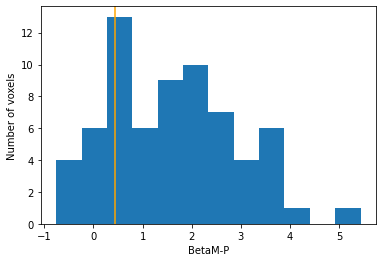

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz: 53 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz: 14 voxels
[14, 53, 77236]
P: ['73.93', '58.29', '10.36']
M: ['74.62', '58.96', '11.26']
[14, 53, 67]


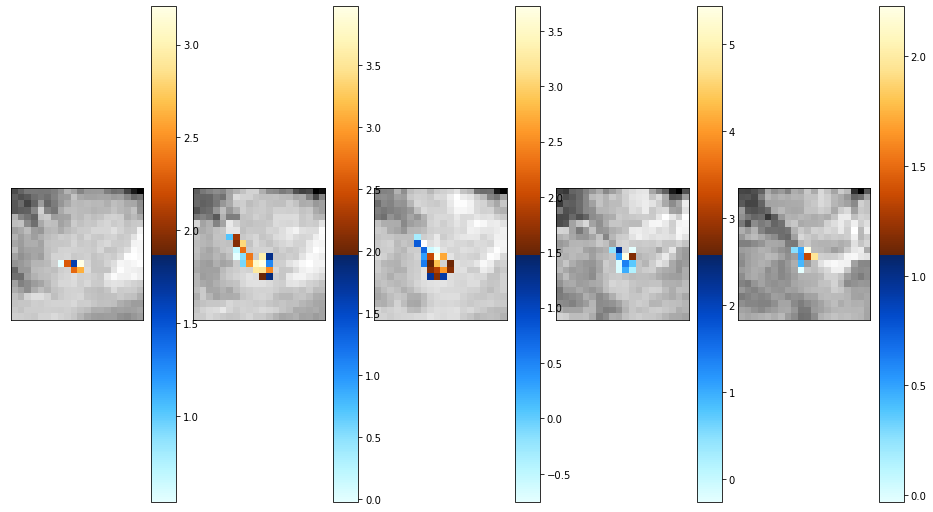

Right:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz
Mask contains 65 voxels and 20th percentile is 0.307853776216507


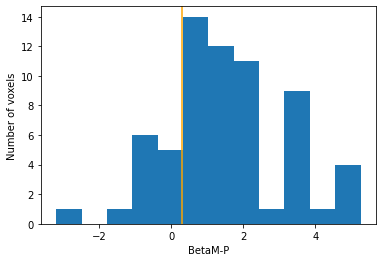

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz: 52 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz: 13 voxels
[13, 52, 77236]
P: ['51.85', '59.08', '11.92']
M: ['51.46', '59.42', '12.17']
[13, 52, 65]


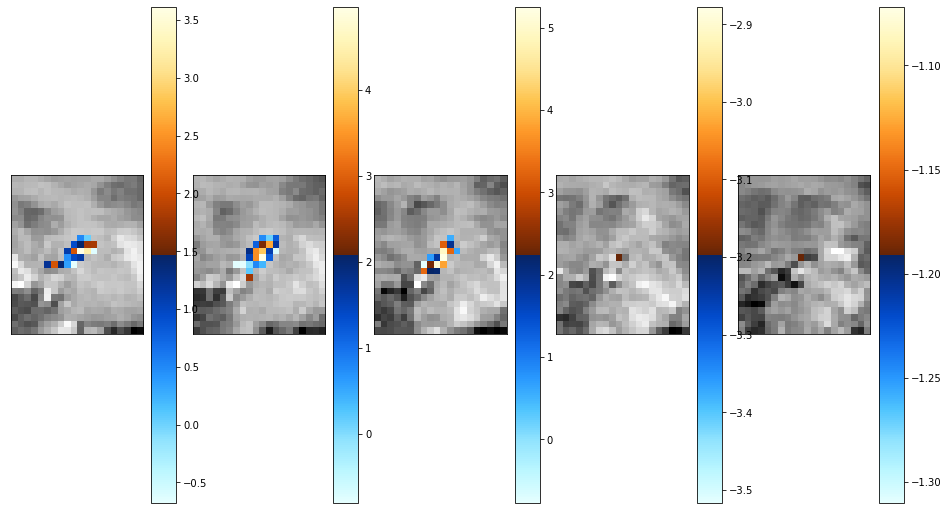

*********

xvalRUN
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun7
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun7/fixedeffects/modelfit/datasink
Left:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz
Mask contains 67 voxels and 20th percentile is 0.2600148916244507


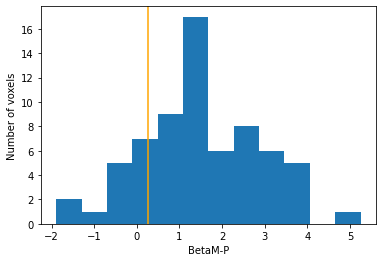

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz: 53 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz: 14 voxels
[14, 53, 77236]
P: ['73.86', '58.21', '10.21']
M: ['74.64', '58.98', '11.30']
[14, 53, 67]


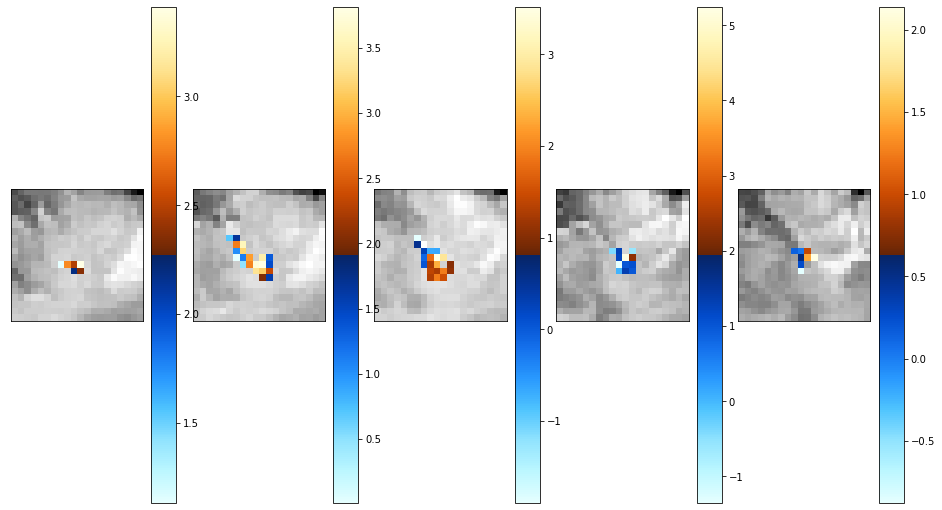

Right:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz
Mask contains 65 voxels and 20th percentile is 0.11832470595836656


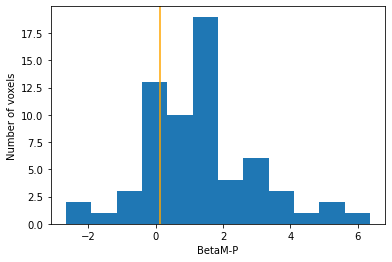

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz: 52 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz: 13 voxels
[13, 52, 77236]
P: ['52.31', '58.62', '12.08']
M: ['51.35', '59.54', '12.13']
[13, 52, 65]


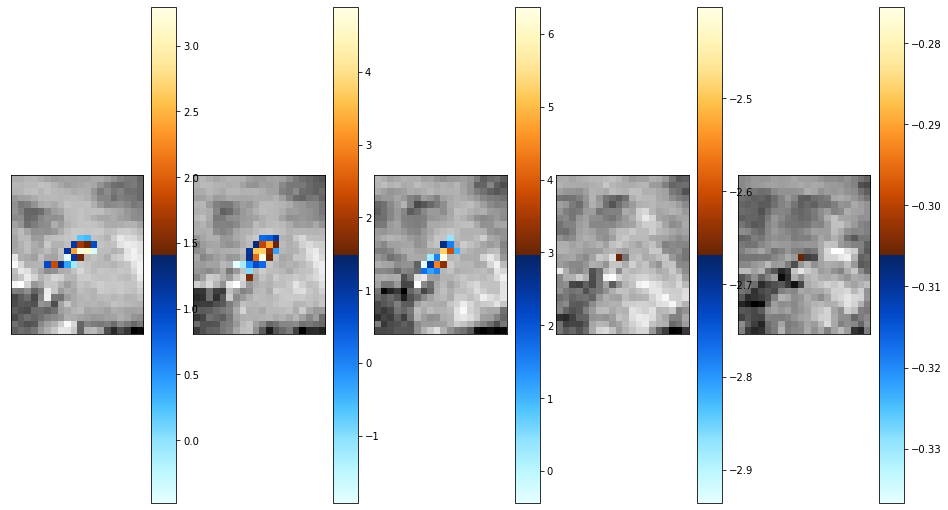

*********

xvalRUN
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun8
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp_excrun8/fixedeffects/modelfit/datasink
Left:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz
Mask contains 67 voxels and 20th percentile is 0.5205647468566895


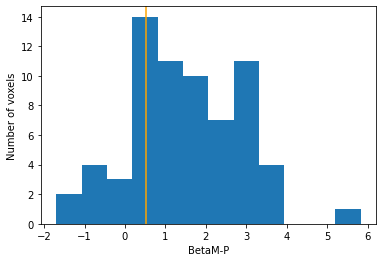

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNM20_roi.nii.gz: 53 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNP20_roi.nii.gz: 14 voxels
[14, 53, 77236]
P: ['73.57', '58.07', '10.29']
M: ['74.72', '59.02', '11.28']
[14, 53, 67]


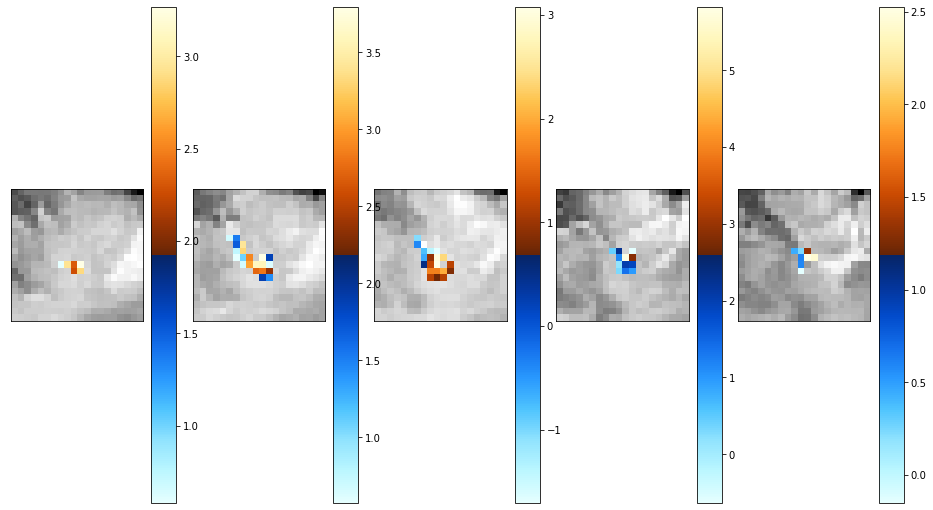

Right:
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGN_roi.nii.gz
will partition at 20% and create
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz
Mask contains 65 voxels and 20th percentile is 0.017289521172642743


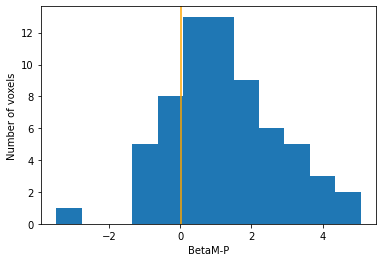

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNM20_roi.nii.gz: 52 voxels
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNP20_roi.nii.gz: 13 voxels
[13, 52, 77236]
P: ['52.46', '58.54', '12.00']
M: ['51.31', '59.56', '12.15']
[13, 52, 65]


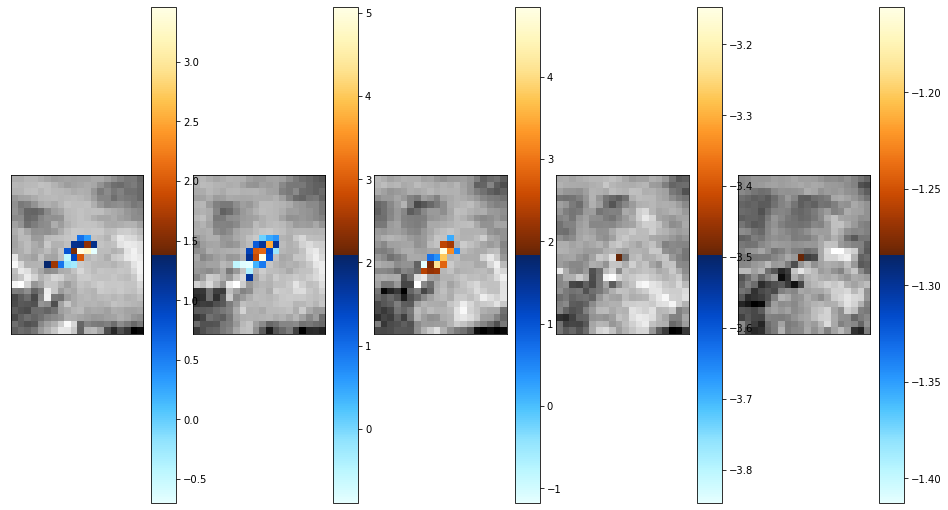

*********



In [45]:
thresholds = np.empty((2, len(mp_xval_outputs)))
for (i, mp_workdir) in enumerate(mp_xval_outputs):
    mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
    print("xvalRUN", mp_workdir, mp_datasink, sep="\n")
    #!ls {mp_datasink}
    _, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
    beta_MP = mp_l2[0]
    beta_MP_img = load_img(beta_MP)
    print("Left:")
    LP_roi, LM_roi, Lthreshold = utils.assign_roi_percentile(rois[0], beta_MP, 20, ref_vol_img, 'L')
    thresholds[0, i] = Lthreshold
    print("Right:")
    RP_roi, RM_roi, Rthreshold = utils.assign_roi_percentile(rois[1], beta_MP, 20, ref_vol_img, 'R')
    thresholds[1, i] = Rthreshold
    print("*********\n")

In [42]:
np.mean(thresholds, axis=1)

array([0.4698, 0.1123])

In [43]:
np.std(thresholds, axis=1)

array([0.1364, 0.1332])

### Viewing and cutting etc

In [ ]:
cut = (-17, -3, 1)

In [ ]:
beta_RL_val = threshold_img(beta_RL, threshold=4.0)

In [ ]:
view_img(beta_RL_val, bg_img=ref_vol_path, cut_coords=cut)

In [ ]:
np.count_nonzero(beta_RL_val.dataobj)

In [ ]:
from nilearn.regions import connected_regions

regions_value_img, index = connected_regions(beta_RL_val,
                                             min_region_size=1500)
title = ("ROIs using image intensity thresholding. "
         "\n Each ROI in same color is an extracted region")
plotting.plot_prob_atlas(regions_value_img, bg_img=ref_vol_path,
                         view_type='auto', display_mode='z',
                         cut_coords=5, title=title)
plotting.show()

### Use BIDSLayout to get files that would be passed to workflow

In [62]:
bold

NameError: name 'bold' is not defined

In [ ]:
anat_file

In [65]:
bolds = sorted(preproc_layout.get(subject=sub, session=ses, task="hemi", extension=['nii.gz'],
                           return_type='file'))
print(bolds)

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_desc-preproc_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_desc-preproc_bold.nii.gz']


In [66]:
#masks = sorted([f for f in preproc_layout.get(subject=sub, suffix='mask',
#            session=ses, run=[], extension=['nii.gz'], return_type='file')])

masks = [mask_file]*2

In [67]:
masks

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz']

In [ ]:
!ls {masks[0]}

In [70]:
raw_bolds = raw_layout.get(subject=sub, suffix="bold",
                           task="hemi", session=ses, run=[1,2], extension=['nii.gz'], return_type='file')

In [71]:
raw_bolds

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_bold.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_bold.nii.gz']

In [72]:
raw_layout.get_tr(raw_bolds[0])

2.25

In [73]:
TRs = [raw_layout.get_tr(f) for f in raw_bolds]

In [74]:
print(TRs)
assert TRs.count(TRs[0])==len(TRs)

[2.25, 2.25]


### Use the actual utils.py function

In [75]:
bolds, masks, eventfiles, TR, confounds = utils.get_files(sub, ses, "mp",
    raw_data_dir, out_dir, run=[1, 2, 3, 4, 5, 6, 7, 8])

//anaconda/envs/py37mri/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


Space is None


ValueError: 'desc' is not a recognized entity. If you're sure you want to impose this constraint, set invalid_filters='allow'.

## Coherence analysis to identify LGN voxels responding at flicker frequency

### raw nibabel

In [76]:
img = nib.load(bold_file)

NameError: name 'bold_file' is not defined

In [ ]:
print(img.header)

In [ ]:
img_data = img.get_fdata()

In [ ]:
plt.imshow(img_data[26, :, :, 44].T, cmap="gray", origin="lower")

In [ ]:
nvox = img.shape[0] * img.shape[1] * img.shape[2]

In [ ]:
n_timepoints = img.shape[-1]

In [ ]:
print(nvox, n_timepoints)

In [ ]:
img_flat = np.reshape(img_data, (nvox, -1))

In [ ]:
img_flat[:10, 0]

In [39]:
#TR = 2.25 # seconds
freq = 4 # Hz
total_len = img.shape[-1]*TR # seconds
fig, ax = plt.subplots(1)
t = np.arange(0.0, total_len, 0.05)
sinusoid = np.sin(freq*2*np.pi*t)
print(sinusoid.shape)

ax.set_xlim(0, 8)
ax.plot(t, sinusoid)

NameError: name 'img' is not defined

In [ ]:
2.25*139

### Begin coherence analysis in nitime

In [78]:
#run = 2
if TRs:
    TR = TRs[0]
else:
    TR = 2.25
#bold_file = f"/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-{run:02d}_desc-preproc_bold.nii.gz"

0.037037037037037035
[  0.     2.25   4.5    6.75   9.    11.25  13.5   15.75  18.    20.25
  22.5   24.75  27.    29.25  31.5   33.75  36.    38.25  40.5   42.75
  45.    47.25  49.5   51.75  54.    56.25  58.5   60.75  63.    65.25
  67.5   69.75  72.    74.25  76.5   78.75  81.    83.25  85.5   87.75
  90.    92.25  94.5   96.75  99.   101.25 103.5  105.75 108.   110.25
 112.5  114.75 117.   119.25 121.5  123.75 126.   128.25 130.5  132.75
 135.   137.25 139.5  141.75 144.   146.25 148.5  150.75 153.   155.25
 157.5  159.75 162.   164.25 166.5  168.75 171.   173.25 175.5  177.75
 180.   182.25 184.5  186.75 189.   191.25 193.5  195.75 198.   200.25
 202.5  204.75 207.   209.25 211.5  213.75 216.   218.25 220.5  222.75
 225.   227.25 229.5  231.75 234.   236.25 238.5  240.75 243.   245.25
 247.5  249.75 252.   254.25 256.5  258.75 261.   263.25 265.5  267.75
 270.   272.25 274.5  276.75 279.   281.25 283.5  285.75 288.   290.25
 292.5  294.75 297.   299.25 301.5  303.75 306.   308.25

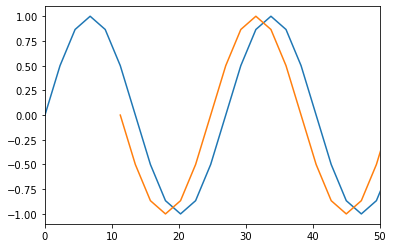

In [79]:
cycle_duration = 27 # (should be 27s)
hemi_freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*TR # seconds
Fs = 1/TR # Sampling freq
trs_exc_beg = 6
trs_exc_end = 1
nperseg = n_trs_func - trs_exc_beg - trs_exc_end

f_lb = 0.02
f_ub = 0.15

print(hemi_freq)

t = np.arange(0.0, total_len, TR)
t_trim = np.arange((trs_exc_beg-1)*TR, (total_len - trs_exc_beg - trs_exc_end)+1, TR)
hemifield_alternation_sinusoid = np.sin(hemi_freq*2*np.pi*t)
hemi_alt_trim = hemifield_alternation_sinusoid[trs_exc_beg:(-1*trs_exc_end)]
print(t, hemifield_alternation_sinusoid.shape)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t_trim, hemi_alt_trim)

#### average the runs

In [80]:
masker = NiftiMasker(detrend=False, standardize="psc", mask_strategy="epi", high_pass=f_lb, low_pass=f_ub, t_r=TR) # 

In [81]:
masker.fit(bolds[0])

NiftiMasker(high_pass=0.02, low_pass=0.15, mask_strategy='epi',
            standardize='psc', t_r=2.25)

In [82]:
print(mask_file)

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz


In [83]:
!ls {mask_file}

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz


In [ ]:
masker.mask_img_.to_filename(mask_file)

In [84]:
mask_img = masker.mask_img_
mask_img.shape

(128, 128, 21)

In [85]:
mean_bold_timeseries = utils.average_timeseries(bolds, masker)

//anaconda/envs/py37mri/lib/python3.7/site-packages/nilearn/signal.py:81: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0 or less. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '


0
(139, 77236, 2)
(139, 77236)
float32
[[      0.           0.        -117.4712    1121.4413       0.    ]
 [      0.           0.        8371.916    18837.04         0.    ]
 [      0.           0.       13445.0625  -25447.367        0.    ]
 [      0.           0.       12844.787  -103044.85         0.    ]
 [      0.           0.        1363.1898  -55481.062        0.    ]]
1
(139, 77236, 2)
(139, 77236)
float32
[[ -163.8383     0.         0.         0.         0.    ]
 [-3736.3154     0.         0.         0.         0.    ]
 [ 1475.5005     0.         0.         0.         0.    ]
 [ 9169.746      0.         0.         0.         0.    ]
 [  822.9002     0.         0.         0.         0.    ]]


In [86]:
mean_bold_timeseries.shape

(139, 77236)

In [87]:
mean_bold_timeseries[:5, :5]

array([[   -81.9191,      0.    ,    -58.7356,    560.7206,      0.    ],
       [ -1868.1577,      0.    ,   4185.958 ,   9418.5195,      0.    ],
       [   737.7502,      0.    ,   6722.5312, -12723.6836,      0.    ],
       [  4584.873 ,      0.    ,   6422.3936, -51522.4258,      0.    ],
       [   411.4501,      0.    ,    681.5949, -27740.5312,      0.    ]])

In [88]:
hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=TR)
hemi_ts_trim = ts.TimeSeries(data=hemi_alt_trim,
                         sampling_interval=TR)

In [89]:
hemi_ts.shape, hemi_ts_trim.shape

((139,), (132,))

In [90]:
mean_bold_timeseries.shape

(139, 77236)

In [91]:
trim_bold_nm = mean_bold_timeseries[trs_exc_beg:(-1*trs_exc_end),:] # note we are using the mean of the two runs
trim_bold_nm.shape

(132, 77236)

### begin coherence stuff

#### dummy stuff to see how coherence works

In [92]:
timepad = np.pad(hemifield_alternation_sinusoid, (3,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad2 = np.pad(hemifield_alternation_sinusoid, (6,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad3 = np.pad(hemifield_alternation_sinusoid, (8,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]

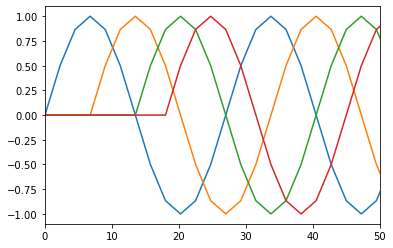

In [93]:
fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t, timepad)
ax.plot(t, timepad2)
ax.plot(t, timepad3)

#### analyze the real fmri data

In [94]:
masked_ts_flat = trim_bold_nm.T # want nvox, n_tp so transpose NiftiMasker result
#demean_ts_flat = demean.T

[ 11.25  13.5   15.75  18.    20.25  22.5   24.75  27.    29.25  31.5
  33.75  36.    38.25  40.5   42.75  45.    47.25  49.5   51.75  54.
  56.25  58.5   60.75  63.    65.25  67.5   69.75  72.    74.25  76.5
  78.75  81.    83.25  85.5   87.75  90.    92.25  94.5   96.75  99.
 101.25 103.5  105.75 108.   110.25 112.5  114.75 117.   119.25 121.5
 123.75 126.   128.25 130.5  132.75 135.   137.25 139.5  141.75 144.
 146.25 148.5  150.75 153.   155.25 157.5  159.75 162.   164.25 166.5
 168.75 171.   173.25 175.5  177.75 180.   182.25 184.5  186.75 189.
 191.25 193.5  195.75 198.   200.25 202.5  204.75 207.   209.25 211.5
 213.75 216.   218.25 220.5  222.75 225.   227.25 229.5  231.75 234.
 236.25 238.5  240.75 243.   245.25 247.5  249.75 252.   254.25 256.5
 258.75 261.   263.25 265.5  267.75 270.   272.25 274.5  276.75 279.
 281.25 283.5  285.75 288.   290.25 292.5  294.75 297.   299.25 301.5
 303.75 306.  ]


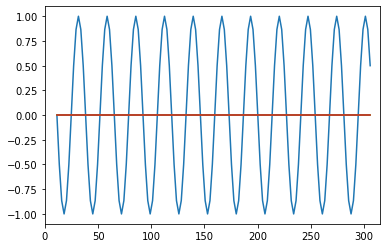

In [95]:
t=t_trim
print(t)
fig, ax = plt.subplots(1)
ax.set_xlim(0, 315)
ax.plot(t, hemi_alt_trim)
ax.plot(t, masked_ts_flat[32, :])
ax.plot(t, masked_ts_flat[3222, :])
ax.plot(t, masked_ts_flat[11513, :])
#ax.plot(t, masked_ts_flat[546434, :])

#### SpectralAnalyzer

In [96]:
bold_flat = ts.TimeSeries(masked_ts_flat[:, :], sampling_interval=TR)
#bold_flat = ts.TimeSeries(demean_ts_flat[:, :], sampling_interval=TR)

In [97]:
bold_flat.sampling_rate

0.4444444444444444 Hz

In [98]:
bold_flat.shape

(77236, 132)

In [99]:
assert(nperseg == masked_ts_flat.shape[-1])

In [100]:
S_original = nta.SpectralAnalyzer(bold_flat, method={'this_method':'welch', 'NFFT':nperseg, 'Fs':bold_flat.sampling_rate})

In [101]:
print(S_original)

SpectralAnalyzer(method={'this_method': 'welch', 'NFFT': 132, 'Fs': 0.4444444444444444 Hz}, BW=None, adaptive=False, low_bias=False)


In [102]:
def plot_spectra(S_original, voxid):
    fig01 = plt.figure()
    ax01 = fig01.add_subplot(1, 1, 1)
    ax01.plot(S_original.psd[0],
              S_original.psd[1][voxid],
              label='Welch PSD')
    print(S_original.psd[0], S_original.psd[1], len(S_original.psd[1]))

    ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1][voxid]),
              label='FFT')
    
    ax01.set_xlabel('Frequency (Hz)')
    ax01.set_ylabel('Power')

    ax01.legend()

In [103]:
voxid = 144

[0.     0.0034 0.0067 0.0101 0.0135 0.0168 0.0202 0.0236 0.0269 0.0303
 0.0337 0.037  0.0404 0.0438 0.0471 0.0505 0.0539 0.0572 0.0606 0.064
 0.0673 0.0707 0.0741 0.0774 0.0808 0.0842 0.0875 0.0909 0.0943 0.0976
 0.101  0.1044 0.1077 0.1111 0.1145 0.1178 0.1212 0.1246 0.1279 0.1313
 0.1347 0.138  0.1414 0.1448 0.1481 0.1515 0.1549 0.1582 0.1616 0.165
 0.1684 0.1717 0.1751 0.1785 0.1818 0.1852 0.1886 0.1919 0.1953 0.1987
 0.202  0.2054 0.2088 0.2121 0.2155 0.2189 0.2222] [[5.0110e+05 2.4008e+05 4.0710e+02 ... 3.2255e-01 3.0660e-01 1.5100e-01]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [4.7801e+05 2.6573e+05 3.3405e+03 ... 2.5460e-01 2.4414e-01 1.2014e-01]
 ...
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [5.2517e+05 2.1474e+05 5.1738e+03 ... 1.1288e-01 9.2818e-02 4.3056e-02]
 [4.9274e+05 2.4922e+05 5.4954e+01 ... 2.4255e-03 1.7494e-03 7.6155e-04]] 77236


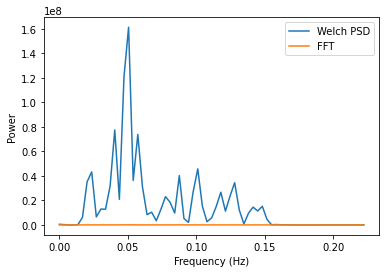

In [104]:
plot_spectra(S_original, voxid)

In [105]:
masked_ts_flat.shape

(77236, 132)

In [106]:
bold_flat.data.shape

(77236, 132)

In [107]:
def comparison_plots(masked_ts_flat, S_original, Fs, nperseg, voxid=1000):
    # Compute PSD with `scipy.signal.welch`
    f_welch, S_welch = scipy.signal.welch(
        masked_ts_flat[voxid, :], fs=Fs, nperseg=nperseg, noverlap=(nperseg // 2),
        detrend=None, scaling='density', window='hanning')

    # Compute PSD with `matplotlib.mlab.psd`, using parameters that are
    # *equivalent* to those used in `scipy.signal.welch` above
    S_mlab, f_mlab = mlab.psd(
        masked_ts_flat[voxid, :], Fs=Fs, NFFT=nperseg, noverlap=(nperseg // 2),
        detrend=None, scale_by_freq=True, window=mlab.window_hanning)

    fig, axes = plt.subplots(3, 1, sharex=True)

    # Plot PSD computed via both methods
    axes[0].plot(f_welch, S_welch, label='scipy.signal.welch')
    axes[0].plot(f_mlab, S_mlab, label='mlab.psd')
    axes[0].set_ylabel('PSD')
    axes[0].legend()

    axes[1].plot(S_original.spectrum_fourier[0],
                  np.abs(S_original.spectrum_fourier[1][voxid]),
                  label='nitime FFT')

    freqs2 = nitime.utils.get_freqs(Fs, masked_ts_flat.shape[-1])
    fft = scipy.fftpack.fft(bold_flat.data)
    scaledAmp = np.abs(fft[:, :freqs2.shape[0]])
    amp = 2*scaledAmp/masked_ts_flat.shape[-1]
    sqrtsummagsq = np.sqrt(np.sum(scaledAmp[:, :]**2))
    print(sqrtsummagsq)
    co = scaledAmp[:,11]/sqrtsummagsq;

    axes[1].plot(freqs2, scaledAmp[voxid], label='ScaledAmp')
    axes[2].plot(freqs2, amp[voxid], label='Amp')
    axes[2].set_xlabel('f')
    axes[1].legend()
    axes[2].legend()

    plt.suptitle(f"voxid {voxid}, co {co[voxid]}")
    plt.show()
    
    return [freqs2, amp, co]

157632992008.3214


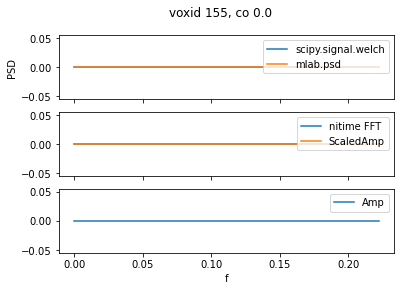

157632992008.3214


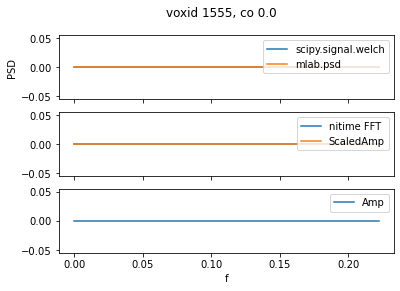

157632992008.3214


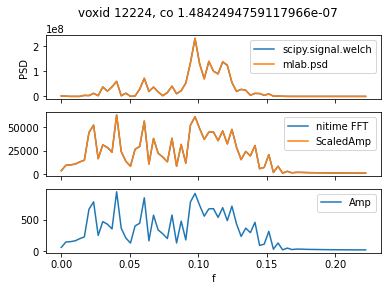

In [108]:
for v in [155, 1555, 12224]:
    _ = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, v)

In [ ]:
[f, a, co] = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, 1000)

In [ ]:
plt.hist(co)

In [ ]:
coh_amp_map = masker.inverse_transform(co)

In [ ]:
coh_amp_map.to_filename(coh_fn)

#### Correlation and Coherence

In [ ]:
full_stim = np.vstack((hemifield_alternation_sinusoid, masked_ts_flat[:1000,:]))

In [ ]:
full_stim.shape

In [ ]:
test_ts = ts.TimeSeries(full_stim, sampling_interval=TR)

In [ ]:
cr1 = nta.CorrelationAnalyzer(test_ts)
print(cr1.corrcoef)
ntv.drawmatrix_channels(cr1.corrcoef, color_anchor=0)

In [ ]:
ch1 = nta.CoherenceAnalyzer(test_ts)
#physiologically relevant freq band
freq_idx = np.where((ch1.frequencies > 0.02) * (ch1.frequencies < 0.15))[0]
coh = np.mean(ch1.coherence[:,:,freq_idx], -1)
coh

In [ ]:
fig03 = ntv.drawmatrix_channels(coh)

In [ ]:
ch1.phase[0,1]

#### SeedCoherenceAnalyzer

In [110]:
n_seeds = 1
A = nta.SeedCoherenceAnalyzer(hemi_ts_trim, bold_flat)#, method=dict(NFFT=32))
B = nta.SeedCorrelationAnalyzer(hemi_ts_trim, bold_flat)
freq_idx = np.where((A.frequencies > f_lb) * (A.frequencies < f_ub))[0]
freq_idx_hemionly = np.where((np.isclose(A.frequencies, hemi_freq)))[0]
#print(freq_idx, freq_idx_hemionly)
print(A.frequencies, A.frequencies[freq_idx], f_lb, f_ub, sep="\n")
cor = []
coh = []

for this_seed in range(n_seeds):
    #print(this_seed, A.coherence[this_seed], A.coherence[this_seed][freq_idx])
    # Extract the coherence and average across these frequency bands:
    print(A.coherence.shape, A.coherence[:, :], A.coherence[:, freq_idx_hemionly], sep="\n")
    coh.append(np.mean(A.coherence[:, freq_idx], -1))  # Averaging on the last dimension
    cor.append(B.corrcoef[this_seed])  # No need to do any additional computation
        
print(f"coh: {coh}", f"cor: {cor}", sep="\n")

[0.     0.0069 0.0139 0.0208 0.0278 0.0347 0.0417 0.0486 0.0556 0.0625
 0.0694 0.0764 0.0833 0.0903 0.0972 0.1042 0.1111 0.1181 0.125  0.1319
 0.1389 0.1458 0.1528 0.1597 0.1667 0.1736 0.1806 0.1875 0.1944 0.2014
 0.2083 0.2153 0.2222]
[0.0208 0.0278 0.0347 0.0417 0.0486 0.0556 0.0625 0.0694 0.0764 0.0833
 0.0903 0.0972 0.1042 0.1111 0.1181 0.125  0.1319 0.1389 0.1458]
0.02
0.15
(77236, 33)
[[2.7928e-03 6.9043e-02 2.8903e-01 ... 8.2045e-01 7.3176e-01 5.9423e-01]
 [       nan        nan        nan ...        nan        nan        nan]
 [3.4641e-06 4.2337e-01 8.8800e-01 ... 1.2722e-01 1.7992e-01 2.0264e-01]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [8.8942e-03 1.0251e-01 7.2105e-01 ... 8.0302e-01 7.8983e-01 7.8237e-01]
 [2.0265e-03 2.1694e-02 6.5830e-01 ... 3.5724e-01 3.8205e-01 3.9562e-01]]
[]
coh: [array([0.3686,    nan, 0.3208, ...,    nan, 0.3984, 0.4148])]
cor: [-0.22715048224185266]


//anaconda/envs/py37mri/lib/python3.7/site-packages/nitime/algorithms/correlation.py:14: RuntimeWarning: invalid value encountered in true_divide
  r = xy / np.sqrt(xx * yy)


In [ ]:
len(coh[0])

In [ ]:
np.count_nonzero(coh[0])

#### Write coherence values to Nifti file

In [ ]:
coherence_img = masker.inverse_transform(coh[0])
coherence_img.shape

In [ ]:
print(coh_fn)

In [ ]:
coherence_img.to_filename(coh_fn)

In [ ]:
!ls "{coh_fn}"

In [ ]:
cmd = f"fsleyes {bolds[0]} {coh_fn}"

In [ ]:
os.system(cmd)

#### Some visualizations

In [ ]:
plt.hist(coh[0])

In [ ]:
plt.boxplot(coh[0])

In [ ]:
np.count_nonzero(coh[0]==0)

### Continue from here...

In [ ]:
lgn_coh_low = 0.17
lgn_coh_high = 0.19
lgn_voxel_mask_coh = np.logical_and((coh[0] > lgn_coh_low), (coh[0] < lgn_coh_high))

In [ ]:
np.count_nonzero(lgn_voxel_mask_coh)

## ROI plotting

In [ ]:
imgs_in_order = [RP_roi, RM_roi, beta_MP_img]
r = 5
c = 3
fig, ax = plt.subplots(nrows=r, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
p_roi, m_roi, beta_mp = img_data
print([np.count_nonzero(x) for x in img_data])
p_roi_masked = np.ma.masked_where(p_roi==0, p_roi)
m_roi_masked = np.ma.masked_where(m_roi==0, m_roi)
p_mask = np.ma.getmask(p_roi_masked)
m_mask = np.ma.getmask(m_roi_masked)
both_mask = np.logical_and(p_mask,m_mask)
beta_masked = np.ma.masked_array(beta_mp, mask=both_mask)
print([np.count_nonzero(~m) for m in [p_mask, m_mask, both_mask]])
ref_vol_data = ref_vol_img.get_data()
for ri in range(r):
    #ax[ri].imshow(ref_vol_data[10:64,50:70,14-ri])
    pos = ax[ri].imshow(beta_masked[40:64,50:70,14-ri], cmap="cyan_orange")
    plt.colorbar(pos, ax=ax[ri])

In [ ]:
imgs_in_order = [LP_roi, LM_roi]
r = 5
c = 2
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
img_data_masked = [np.ma.masked_where(img==0, img) for img in img_data]
ref_vol_data = ref_vol_img.get_data()
    #plot_roi(imgdata[slice(70,80), slice(55,65), slice(10,15)])
for ri in range(r):
    for ci in range(c):
        ax[ri, ci].imshow(ref_vol_data[64:-20,:,14-ri])
        ax[ri, ci].imshow(img_data_masked[ci][64:-20,:,14-ri], cmap="binary")

In [ ]:
imgs_in_order=[RP_roi, RM_roi]
r = 5
c = 2
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
img_data_masked = [np.ma.masked_where(img==0, img) for img in img_data]
ref_vol_data = ref_vol_img.get_data()
    #plot_roi(imgdata[slice(70,80), slice(55,65), slice(10,15)])
for ri in range(r):
    for ci in range(c):
        ax[ri, ci].imshow(ref_vol_data[10:64,:,14-ri])
        ax[ri, ci].imshow(img_data_masked[ci][10:64,:,14-ri], cmap="binary")

In [ ]:
def view_copes(datasink, contrasts, **kwargs):
    l1copes, l2copes = utils.get_model_outputs(datasink, contrasts)
    return nilearn.plotting.view_img(l2copes[0], **kwargs)

In [ ]:
view_copes(mp_datasink, [3], bg_img=ref_vol_path, threshold="90%", vmax=3, cut_coords=cut)

In [ ]:
def plot_lgn(datasink, contrasts, **kwargs):
    l1copes, l2copes = utils.get_model_outputs(datasink, contrasts)
    return nilearn.plotting.plot_img(l2copes[0], **kwargs)

In [ ]:
plot_lgn(mp_datasink, [3], threshold=2, cut_coords=cut, bg_img=ref_vol_path)

In [ ]:
view_copes(hemi_datasink, [3], bg_img=ref_vol_path, threshold=2, vmax=5, cut_coords=(-17, -3, 1))

In [ ]:
LP_roi.get_data().shape

In [ ]:
roi_fig = plt.figure(figsize=(10, 5))
plot_roi(LP_roi, bg_img=ref_vol_path, display_mode='x',
         cut_coords=range(-23, -14), cmap=plt.get_cmap("brown_cyan"),
        figure=roi_fig)
roi_fig2 = plt.figure(figsize=(10, 5))
plot_roi(LP_roi, bg_img=anat_file, display_mode='x',
         cut_coords=range(-23, -14), cmap=plt.get_cmap("brown_cyan"),
        figure=roi_fig2)

In [ ]:
plot_roi(LP_roi, bg_img=ref_vol_path, cut_coords=cut)